In [2]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

In [3]:
import numpy as np
from PIL import Image as im
from matplotlib import pyplot as plt

bamdad = np.array(im.open("Bamdad.png"))[:,:,0]
jingwei = np.array(im.open("Jingwei.png"))[:,:,0]

In [4]:
y,x  = np.where(bamdad < 255)
y = -1 * y
bamdad = jnp.array(jnp.vstack([x,y]).T.astype(float))

y,x  = np.where(jingwei < 255)
y = -1 * y
jingwei = jnp.array(jnp.vstack([x,y]).T.astype(float))

In [5]:

stacked = jnp.vstack([bamdad,jingwei])
meanval = jnp.mean(stacked,axis=0)
scale = jnp.max(jnp.abs(stacked-meanval),axis=0)

bamdad = (bamdad - meanval)/scale
jingwei = (jingwei - meanval)/scale




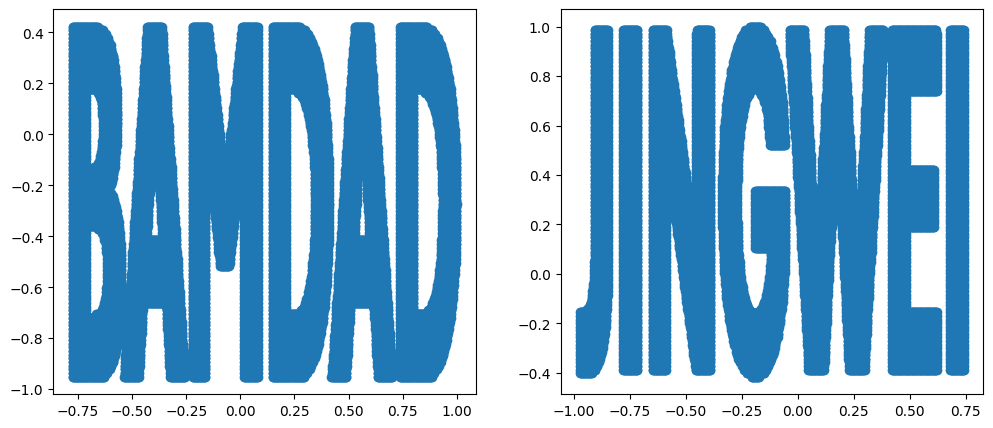

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(bamdad[:,0],bamdad[:,1])
plt.subplot(1,2,2)
plt.scatter(jingwei[:,0],jingwei[:,1])

In [7]:
reference_samples = bamdad
target_samples = jingwei

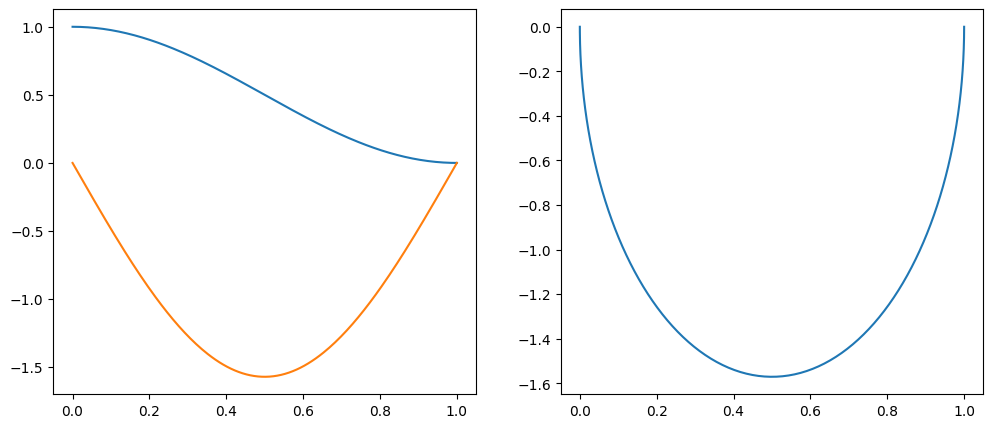

In [34]:
def f(t):
    return ((jnp.cos(t*jnp.pi)+1)/2)# * ((1-t)**2)

def ft(t):
    return -1 * (jnp.pi/2) * jnp.sin(t*jnp.pi)


plt.figure(figsize=(12,5))
tgrid = jnp.linspace(0,1,200)
plt.subplot(1,2,1)
plt.plot(tgrid,f(tgrid))
plt.plot(tgrid,ft(tgrid))
plt.subplot(1,2,2)
plt.plot(f(tgrid),ft(tgrid))

In [58]:
from loss_functions import get_linear_interpolants

def I(t,x,y):
    return x*f(t) + y*(1-f(t))

def It(t,x,y):
    return x*ft(t)- y *ft(t)


#I,It = get_linear_interpolants()
def gamma(t):
    return 0.2 * root_prod_gamma(t)

def gammadot(t):
    return 0.2 * root_prod_gammadot(t)

loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [2048,2048,2048,2048], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [2048,2048,2048,2048], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 256

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(2048,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [59]:
scheduler = optax.piecewise_constant_schedule(
    5e-3,
    {
        10000:0.5,
        20000:0.2,
        30000:0.5,
        60000:0.2,
        80000:0.2,
        100000:0.5
    }
)
b_optim = optax.chain(
   optax.clip_by_global_norm(20.),
   optax.nadamw(scheduler),
)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 125000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/125000 [00:00<?, ?it/s]

step=0 | train_loss=0.028373802 | test_loss= 28794.523
step=5000 | train_loss=2.5598316 | test_loss= 0.051781435
step=10000 | train_loss=5.309818 | test_loss= 2.5230498
step=15000 | train_loss=0.2530775 | test_loss= 0.122092366
step=20000 | train_loss=0.15283927 | test_loss= 0.1012386
step=25000 | train_loss=-0.11902527 | test_loss= -0.08947465
step=30000 | train_loss=-0.043118782 | test_loss= -0.09481495
step=35000 | train_loss=-0.027827367 | test_loss= -0.09396444
step=40000 | train_loss=-0.08375589 | test_loss= -0.09086434
step=45000 | train_loss=-0.042148218 | test_loss= -0.09699512
step=50000 | train_loss=-0.09503827 | test_loss= -0.09459278
step=55000 | train_loss=0.019035786 | test_loss= -0.08006368
step=60000 | train_loss=-0.11191729 | test_loss= -0.06345734


KeyboardInterrupt: 

In [37]:
b_loss_history = jnp.array(b_loss_history)

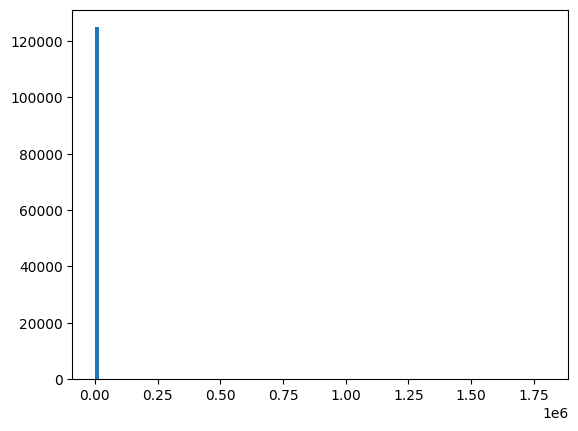

In [40]:
plt.hist(np.array(b_loss_history),100)
plt.show()

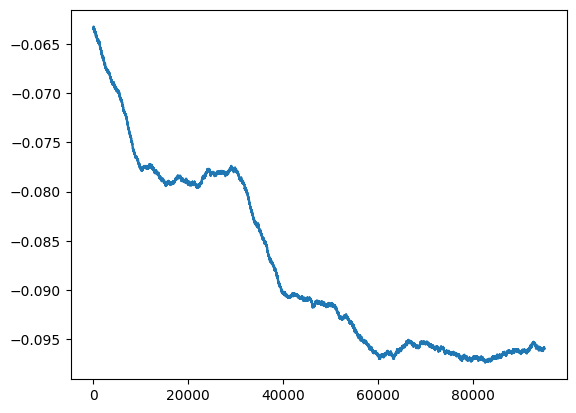

In [42]:
cs = jnp.cumsum(b_loss_history)[20000:]
subsample = 20
num_ave = 10000

plt.plot((cs[num_ave:] - cs[:-num_ave])/num_ave)

In [ ]:
step=124999 | train_loss=-1.1651678 | test_loss= -1.1258626


In [43]:
scheduler = optax.piecewise_constant_schedule(
    1e-3,
    {
        10000:0.5,
        30000:0.5,
        60000:0.2,
        80000:0.2,
        100000:0.5
    }
)

eta_optim = optax.nadamw(scheduler)


eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 500,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)

  0%|          | 0/500 [00:00<?, ?it/s]

step=0 | train_loss=0.0021423064 | test_loss= 110.8624
step=499 | train_loss=4.7724923e-05 | test_loss= 6.054212e-05


In [44]:
from stochastic_interpolant.sampler import StochasticSampler
from diffrax import SaveAt

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = GaussianReferenceSampler((2,)).sample_batch(10000,jax.random.PRNGKey(100))
saveat = SaveAt(
    ts = jnp.linspace(0,1,20),
    dense = True
)
X1,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.0,dt0 = 2e-3,saveat=saveat)

2024-05-17 08:46:56.693741: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 16.93GiB (18176459424 bytes) by rematerialization; only reduced to 17.89GiB (19205280760 bytes), down from 17.89GiB (19205280760 bytes) originally


In [45]:
sigma = 0.5
def k_single(x,y):
    return jnp.exp(-jnp.sqrt(jnp.sum(x-y)**2/(2*sigma**2)))
def vectorize_kfunc(k):
    return jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
k = vectorize_kfunc(k_single)

@jax.jit
def MMD(X,Y):
    return jnp.mean(k(X,X)) +jnp.mean(k(Y,Y)) - 2 * jnp.mean(k(X,Y))

num_samps = 50000
train_loader = build_trainloader(num_samps,jax.random.PRNGKey(124),data_coupling_sampler)
t,x,y,z = next(train_loader)


time_points = jnp.linspace(0,1.,200)
MMD_vals = []
for tpoint in time_points:
    Xval_t = sol.evaluate(tpoint)
    dist_points = I(tpoint*jnp.ones((num_samps,1)),x,y)
    MMD_vals.append(MMD(Xval_t,dist_points))

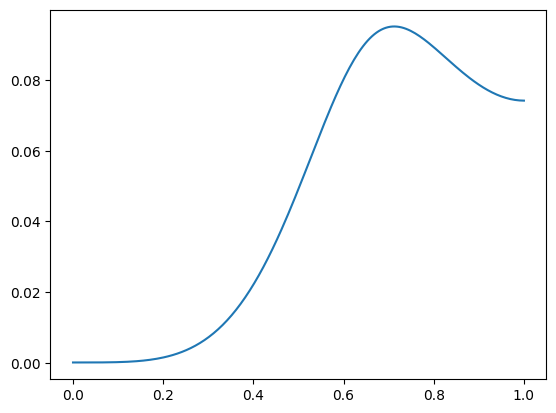

In [46]:
plt.plot(time_points,MMD_vals)

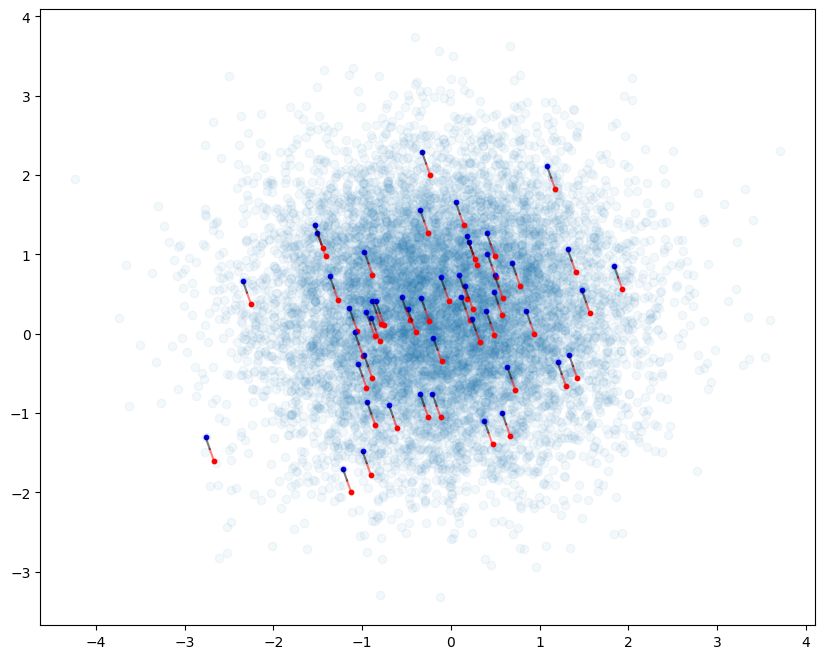

In [47]:
num_trajectories = 50

time_points = np.linspace(0,0.5,100)
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X1[:num_trajectories,0],X1[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

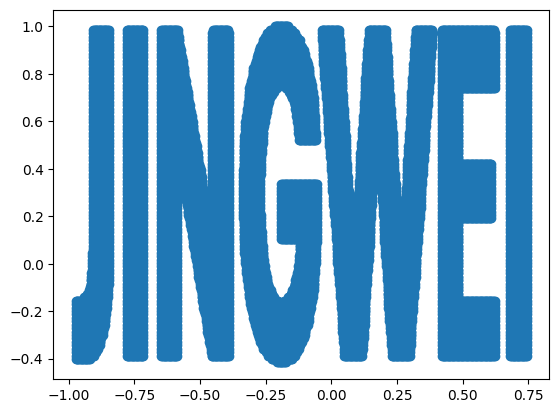

In [100]:
plt.scatter(target_samples[:,0],target_samples[:,1])

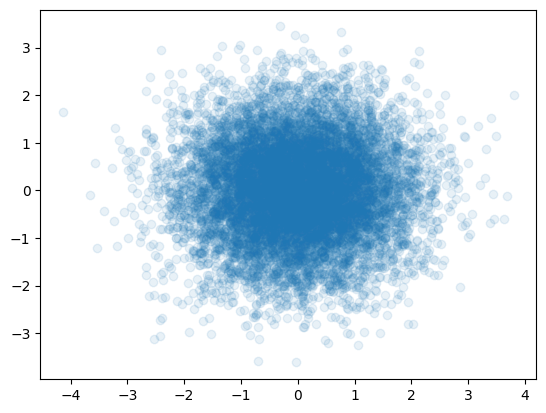

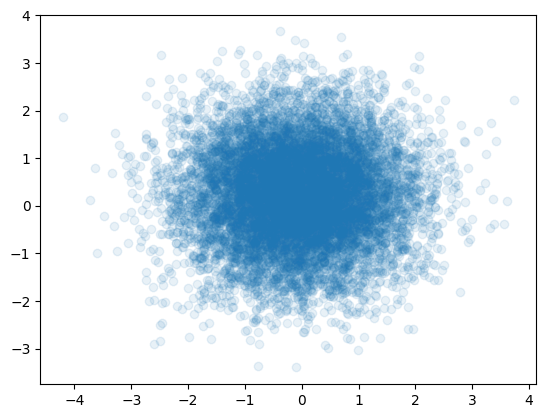

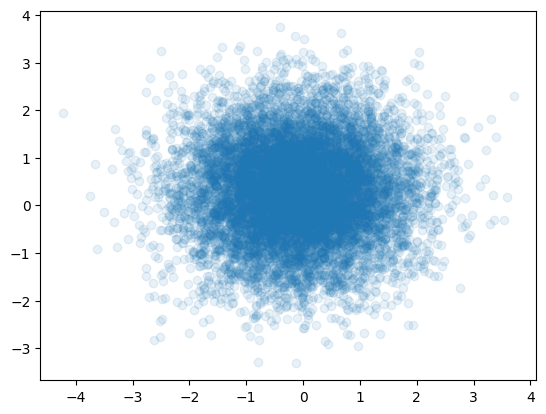

In [48]:
t = 0.0
plt.scatter(sol.evaluate(t)[:,0],sol.evaluate(t)[:,1],alpha =0.1)
plt.show()
t = 0.75
plt.scatter(sol.evaluate(t)[:,0],sol.evaluate(t)[:,1],alpha =0.1)
plt.show()
t = 1
plt.scatter(sol.evaluate(t)[:,0],sol.evaluate(t)[:,1],alpha =0.1)
plt.show()

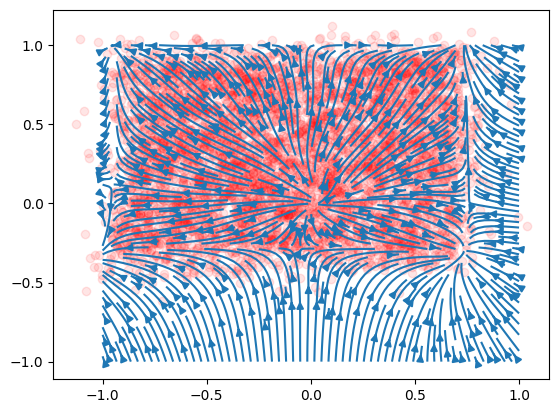

In [159]:
tpoint = 0.95
XX,YY = jnp.meshgrid(jnp.linspace(-1,1,50),jnp.linspace(-1,1,50))

b_input = jnp.vstack([tpoint*jnp.ones(len(XX.flatten())),XX.flatten(),YY.flatten()]).T

result = jax.vmap(b_model)(b_input)
u = result[:,0].reshape(XX.shape)
v = result[:,1].reshape(XX.shape)

plt.streamplot(np.array(XX),np.array(YY),np.array(u),np.array(v),density = 2,minlength = 0.001,maxlength = 1)

plt.scatter(sol.evaluate(tpoint)[:,0],sol.evaluate(tpoint)[:,1],alpha =0.1,c='red')
plt.show()

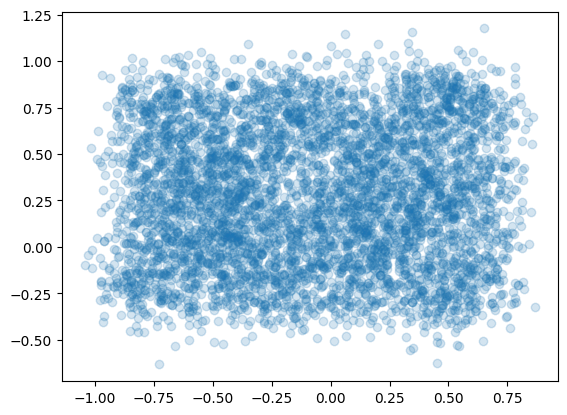

In [170]:
num_samps = 10000

train_loader = build_trainloader(num_samps,jax.random.PRNGKey(124),data_coupling_sampler)
t,x,y,z = next(train_loader)

tpoint = 0.91
dist_points = I(tpoint*jnp.ones((num_samps,1)),x,y) # + gamma(tpoint)*z

plt.scatter(dist_points[:,0],dist_points[:,1],alpha = 0.1)

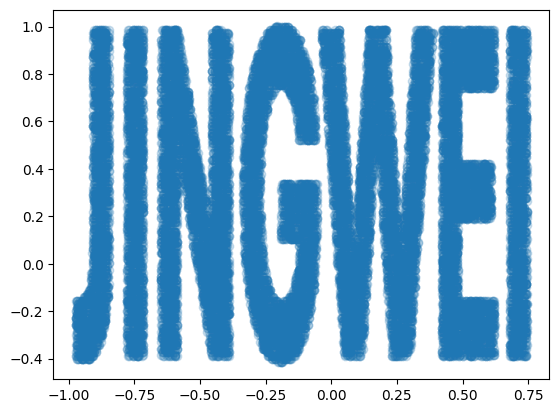

In [57]:
tpoint = 0.99
dist_points = I(tpoint*jnp.ones((num_samps,1)),x,y)
plt.scatter(dist_points[:,0],dist_points[:,1],alpha = 0.1)

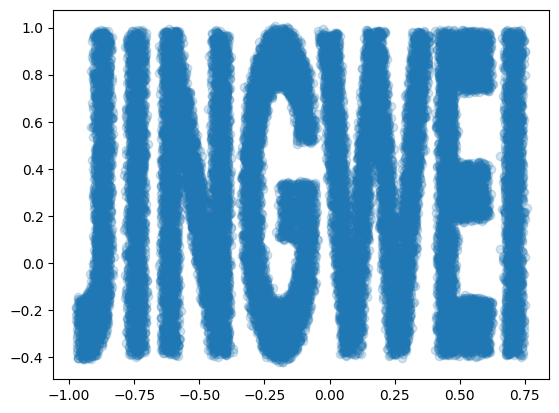